<a href="https://colab.research.google.com/github/cassidyhanna/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/%20U2%2CS1%2CM3_Ridge_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')



In [0]:
import pandas as pd
import numpy as np
import pandas_profiling
import category_encoders as ce

from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


np.seterr(divide='ignore', invalid='ignore')

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

#a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' 
df = df[df.BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS']
#a subset of the data were sale price was more than 100 thousand and less than 2 million.
df = df[df.SALE_PRICE  > 100000 ]
df = df[df.SALE_PRICE < 2000000]

# date time
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

# drop columns not needed / high Cardinality 
df = df.drop(columns = ['APARTMENT_NUMBER', 'ADDRESS','LAND_SQUARE_FEET', 'EASE-MENT'])
# Train Test Split

train = df[df['SALE_DATE'] <= '03/31/2019']
test = df[df['SALE_DATE'] >= '04/01/2019']

# Sale date is high Cardinality 
train = train.drop(columns = ['SALE_DATE'])
test = test.drop(columns = ['SALE_DATE'])

print(train.shape,test.shape)

(2507, 16) (644, 16)


In [0]:
target = 'SALE_PRICE'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2507, 15) (2507,) (644, 15) (644,)


In [0]:
#Encode
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2507, 48) (2507,) (644, 48) (644,)


In [0]:
#SelectKbest
selector = SelectKBest(score_func=f_regression, k=15)
X_train_selected = selector.fit_transform(X_train,y_train)
X_test_selected = selector.transform(X_test)


In [0]:
print(X_train_selected.shape, X_test_selected.shape)

(2507, 15) (644, 15)


In [0]:
# Check which features were selected

for k in range(1, len(X_train.columns)+1):

  print (f'{k} features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train,y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected,y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test,y_pred)

  print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $183,641 

2 features
Test MAE: $182,569 

3 features
Test MAE: $182,569 

4 features
Test MAE: $183,441 

5 features
Test MAE: $181,935 

6 features
Test MAE: $176,456 

7 features
Test MAE: $177,001 

8 features
Test MAE: $176,707 

9 features
Test MAE: $171,663 

10 features
Test MAE: $170,977 

11 features
Test MAE: $170,507 

12 features
Test MAE: $162,301 

13 features
Test MAE: $163,559 

14 features
Test MAE: $162,562 

15 features
Test MAE: $162,564 

16 features
Test MAE: $162,419 

17 features
Test MAE: $162,419 

18 features
Test MAE: $162,177 

19 features
Test MAE: $162,177 

20 features
Test MAE: $157,893 

21 features
Test MAE: $157,966 

22 features
Test MAE: $157,966 

23 features
Test MAE: $157,966 

24 features
Test MAE: $157,966 

25 features
Test MAE: $157,697 

26 features
Test MAE: $157,578 

27 features
Test MAE: $157,511 

28 features
Test MAE: $157,468 

29 features
Test MAE: $158,331 

30 features
Test MAE: $158,428 

31 features
Test MA

In [0]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

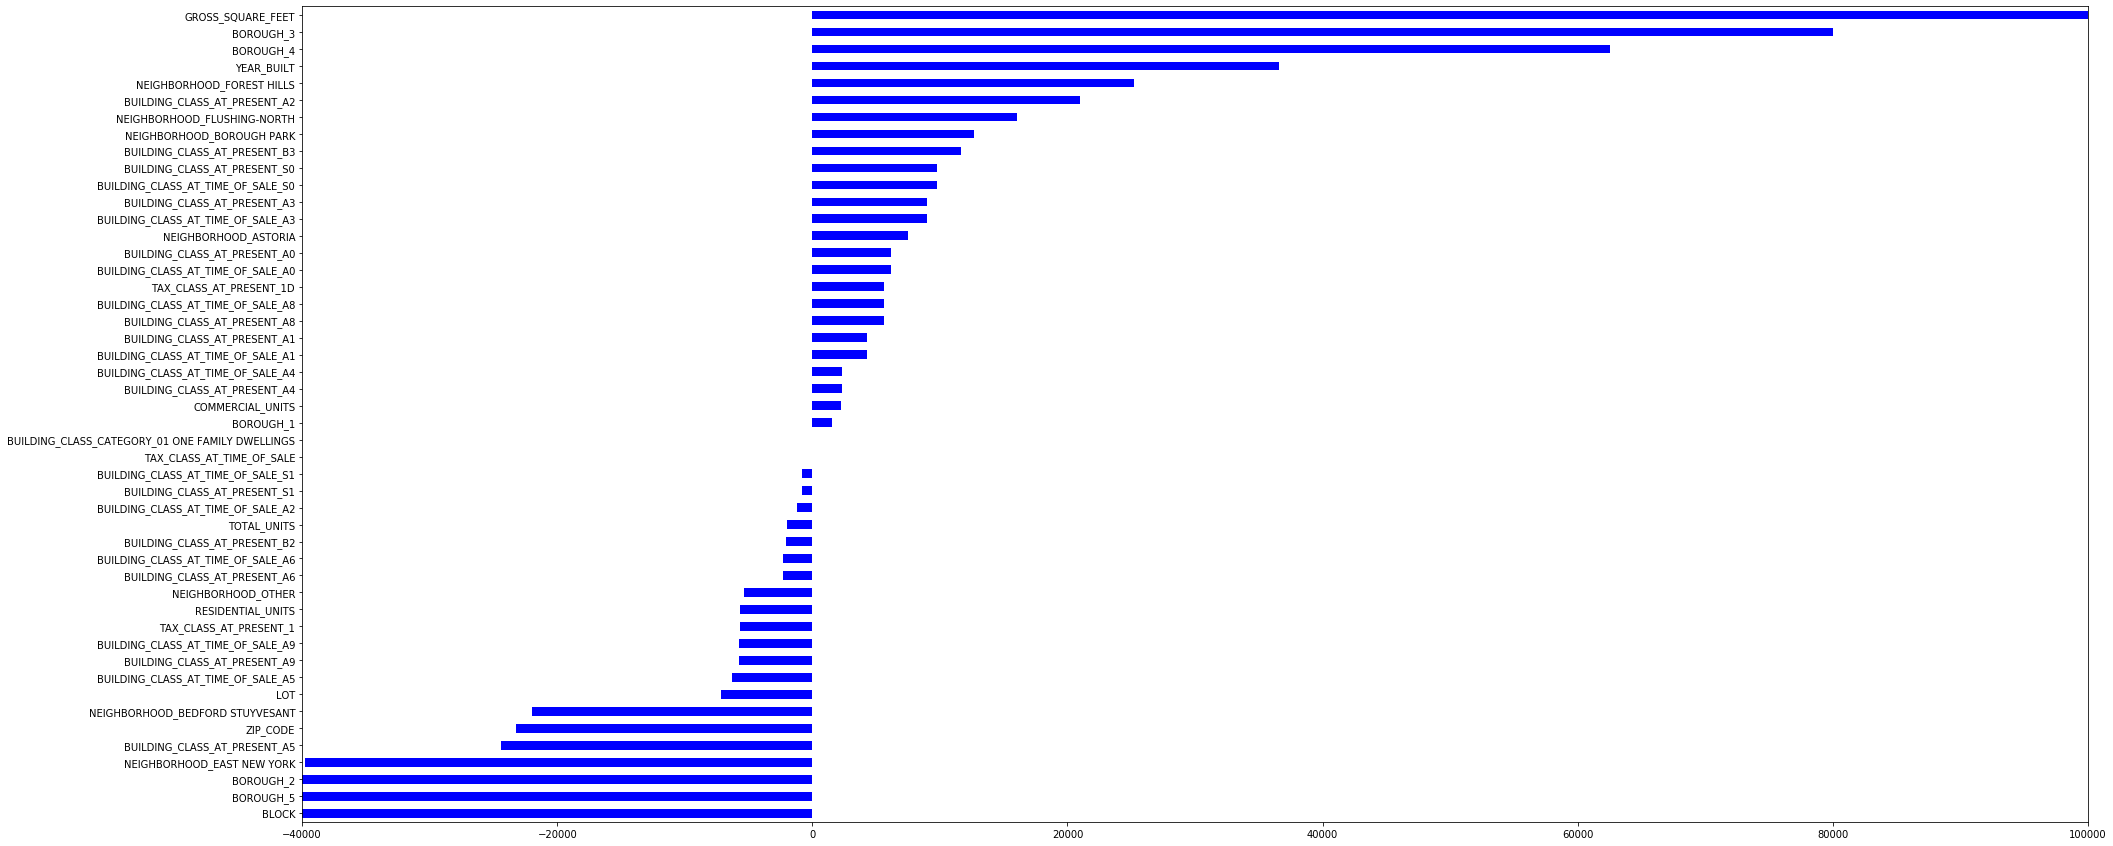

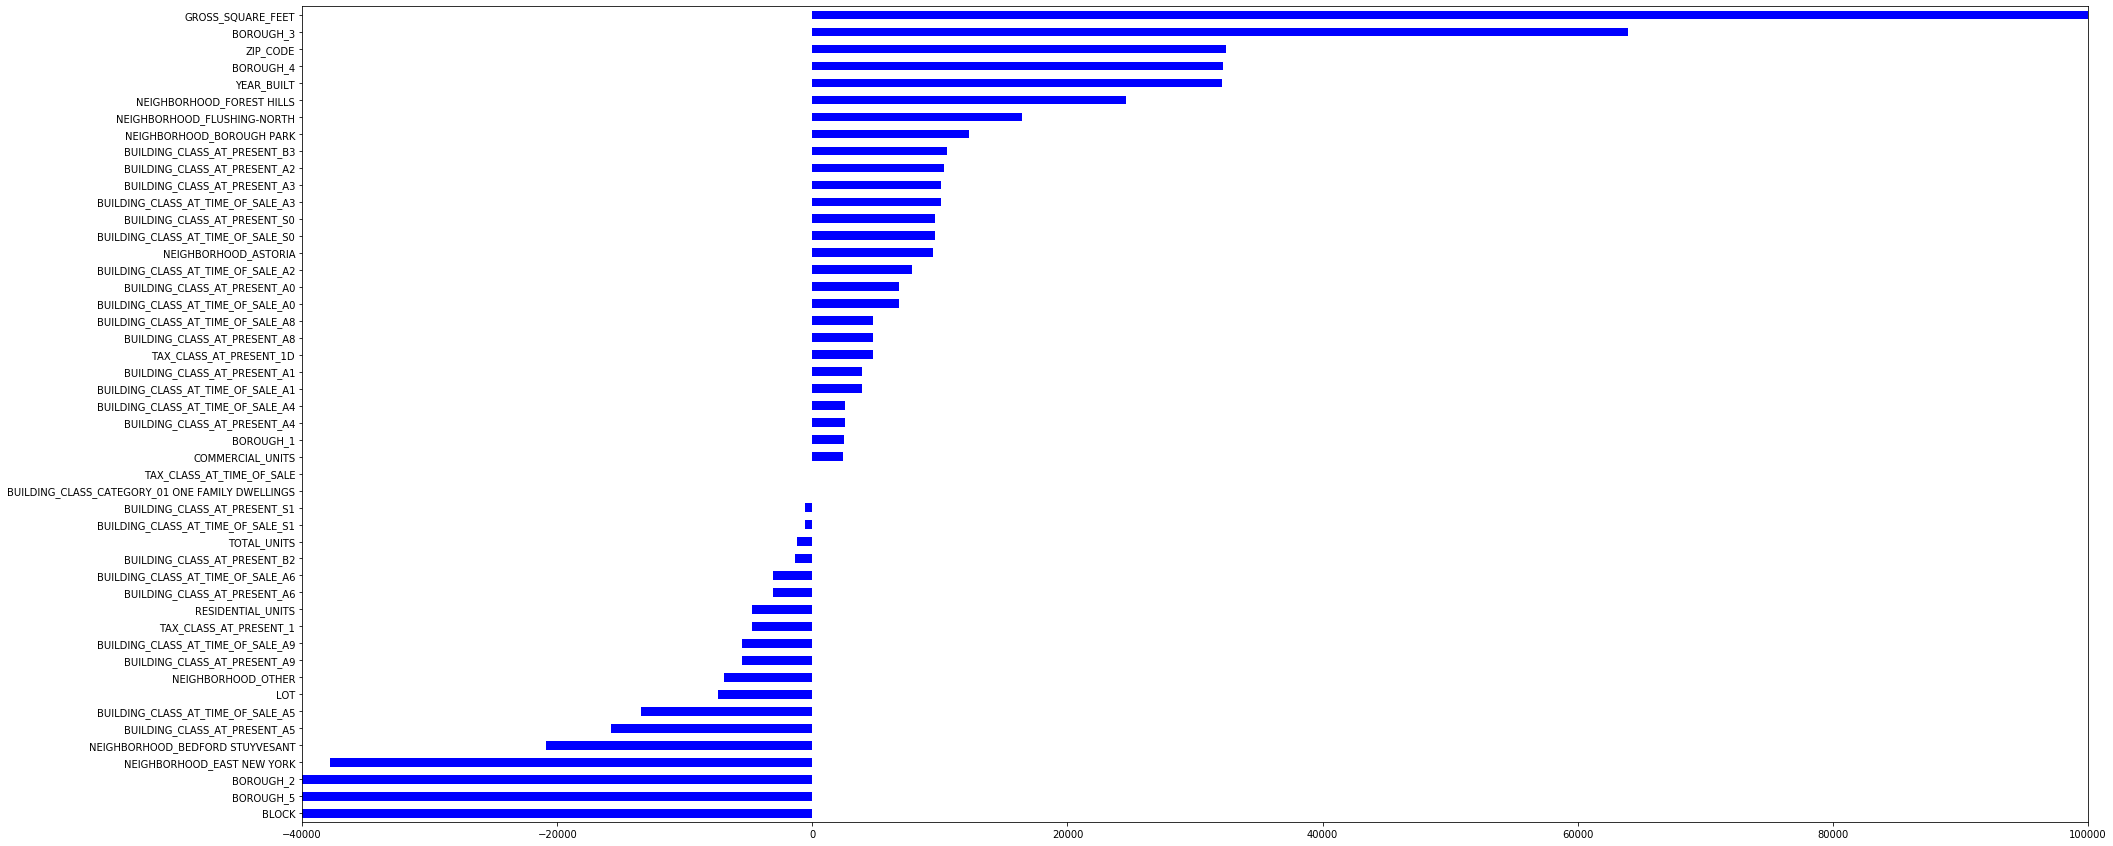

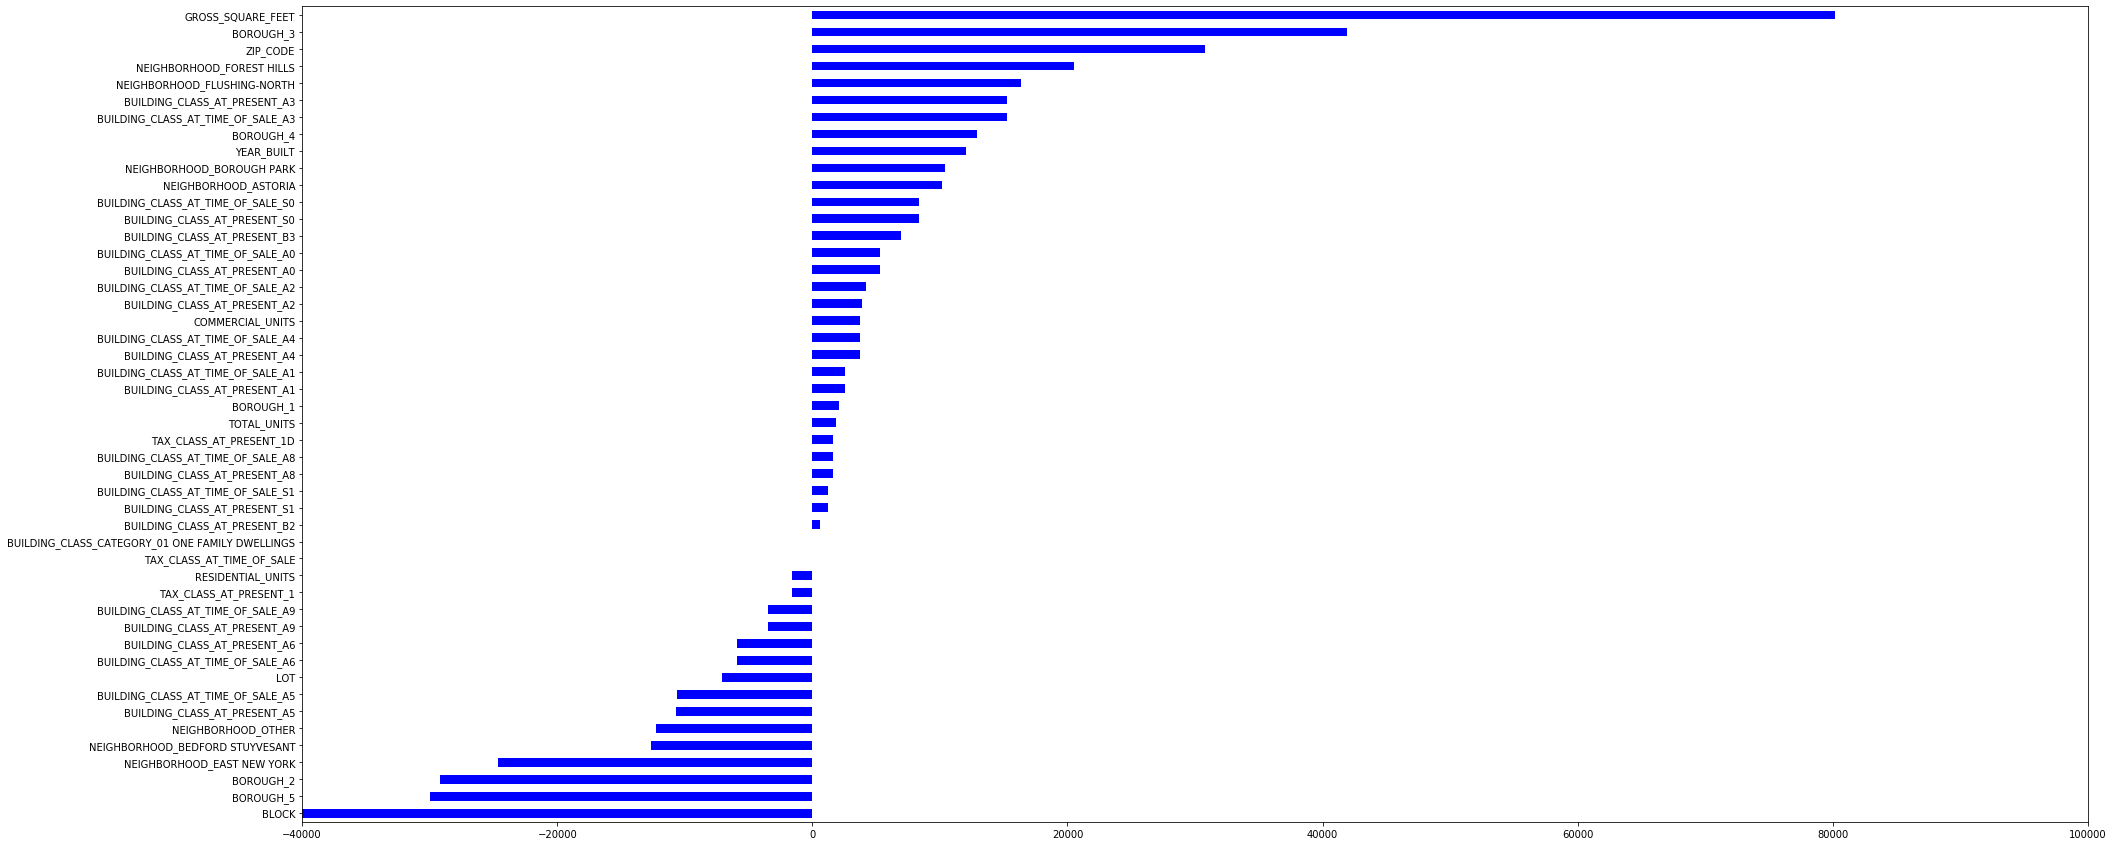

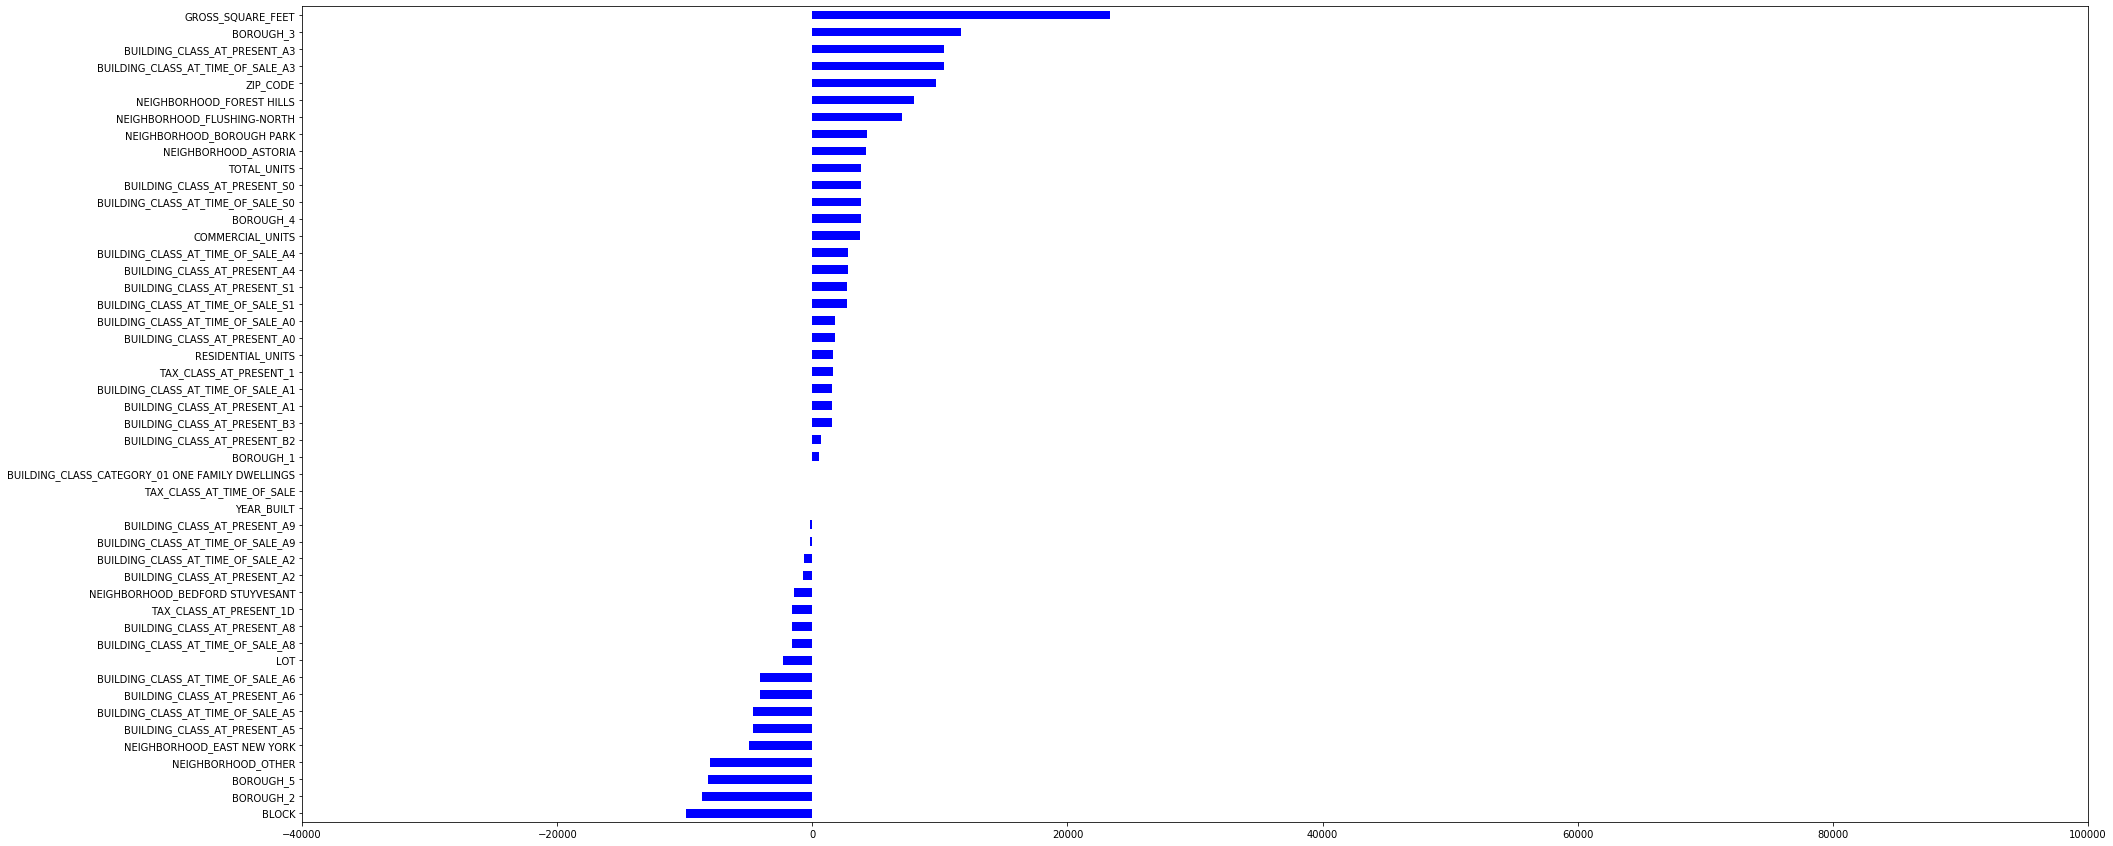

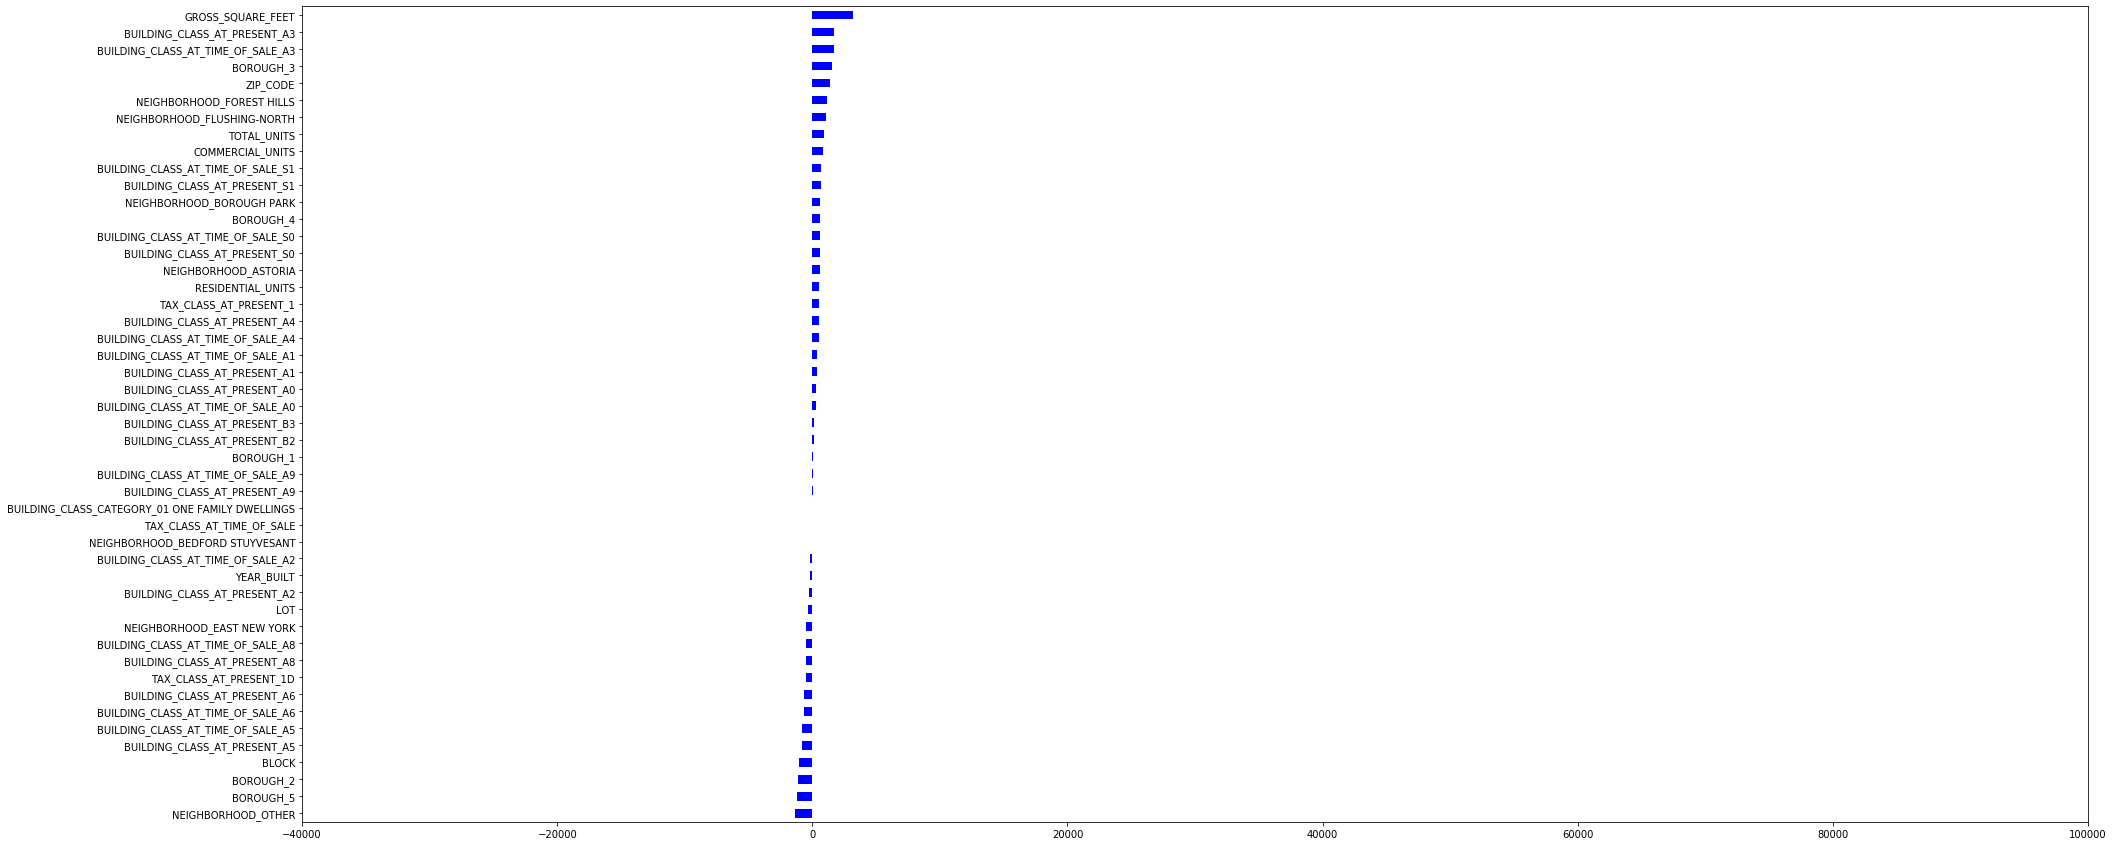

In [0]:
for alpha in [10**1, 10**2, 10**3,10**4,10**5]:

  #Scale 
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  #fit Ridge Regression Model
  display(HTML(f'Ridge Regression, with alpha={alpha}'))
  RR_model = Ridge(alpha=alpha)
  RR_model.fit(X_train_scaled,y_train)
  y_pred = RR_model.predict(X_test_scaled)

  #MAE
  mae = mean_absolute_error(y_test, y_pred)
  display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))

  # plot Coef

  coefficients = pd.Series(RR_model.coef_, X_train.columns)
  plt.figure(figsize=(32,15))
  coefficients.sort_values().plot.barh(color = 'blue')
  plt.xlim(-40000,100000)
  plt.show()
